<a href="https://colab.research.google.com/github/claudiamoses/DataScience-Class-Projects/blob/main/Copy_of_DATASCI_112_Lab_3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authorship of the Federalist Papers

The _Federalist Papers_ were a set of 85 essays published between 1787 and 1788 to promote the ratification of the United States Constitution. They were originally published under the pseudonym "Publius". Although the identity of the authors was a closely guarded secret at the time, most of the papers have since been conclusively attributed to one of Hamilton, Jay, or Madison. The known authorships can be found in `https://dlsun.github.io/pods/data/federalist/authorship.csv`.

For 15 of the papers, however, the authorships remain disputed. (These papers can be identified from the `authorship.csv` file because the "Author" field is blank.) In this analysis, you will use the papers with known authorship to predict the authorships of the disputed papers. The text of each paper is available at `https://dlsun.github.io/pods/data/federalist/#.txt`, where `#` is the number of the paper (i.e., a number from 1 to 85). The name of the file indicates the number of the paper.

## Question 1

When analyzing an author's style, common words like "the" and "on" are actually more useful than rare words like "hostilities". That is because rare words typically signify context. Context is useful if you are trying to find documents about similar topics, but not so useful if you are trying to identify an author's style because different authors can write about the same topic. For example, both Dr. Seuss and Charles Dickens used rare words like "chimney" and "stockings" in _How the Grinch Stole Christmas_ and _A Christmas Carol_, respectively. But they used common words very differently: Dickens used the word "upon" over 100 times, while Dr. Seuss did not use "upon" even once.

Read in the Federalist Papers. Create a term-frequency matrix consisting of only the 50 most common words in the corpus. (Because we are restricting to the most common words already, there is no reason to reweight them using TF-IDF.)

- Feel free to just use `CountVectorizer` with the default `token_pattern`.
- Take a look at the `max_features=` argument of [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

Print out this term-frequency matrix as a `DataFrame`. Make sure the index is the number of the paper and the column names are the most common words.

Save this `DataFrame` to a CSV file using [`DataFrame.to_csv`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) and **download the file to your local machine**.

- You can download the CSV file from the file browser (folder icon in the sidebar).
- If you come back to this lab later, upload this CSV file to the file browser and read it into Colab, rather than re-reading the data from the web.
- You will need this CSV file for Part B of this lab.

In [ ]:
import pandas as pd
import requests

In [ ]:
# read in all 85 papers
papers_dir = "https://dlsun.github.io/pods/data/federalist/"
docs = {}

for i in range(1, 86):
  filename = str(i)
  response = requests.get(papers_dir + str(i) + ".txt", "r")
  docs[filename] = response.text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#count words in each doc and add to dataframe
vec = CountVectorizer(max_features=50)
vec.fit(docs.values())
vectorized_data = vec.transform(docs.values())
tf_df = pd.DataFrame(vectorized_data.toarray(), index=docs.keys(), columns=vec.get_feature_names_out())
tf_df.to_csv("FederalistPapersAuthorship.csv")

## Question 2

Make a visualization that summarizes the most common words used by Hamilton, Madison, and Jay.

Try to make your visualization so that it provides insight into the _differences_ between the ways these three writers used language.

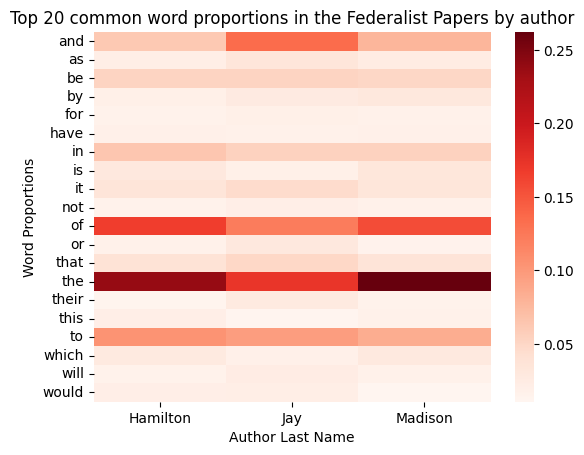

In [ ]:
# Create dataframe of 20 most common words
vec = CountVectorizer(max_features=20)
vec.fit(docs.values())
vectorized_data = vec.transform(docs.values())
tf_t20_df = pd.DataFrame(vectorized_data.toarray(), index=docs.keys(), columns=vec.get_feature_names_out())
tf_t20_df

# Create dataframes for each author's work
authors_df = pd.read_csv("https://dlsun.github.io/pods/data/federalist/authorship.csv")
hamilton_df = authors_df.loc[authors_df["Author"] == "Hamilton"].reset_index()
jay_df = authors_df.loc[authors_df["Author"] == "Jay"].reset_index()
madison_df = authors_df.loc[authors_df["Author"] == "Madison"].reset_index()
madison_df

# Create a list of indices for each author
hamilton_paper_indices = list(hamilton_df["index"])
jay_paper_indices = list(jay_df["index"])
madison_paper_indices = list(madison_df["index"])

# Create df for average number of appearances of each word in tf_df for each author
hamilton_proportions = (tf_t20_df.iloc[hamilton_paper_indices].mean(axis="rows\
")) / (tf_t20_df.iloc[hamilton_paper_indices].sum(axis="columns")).mean()
jay_proportions = tf_t20_df.iloc[jay_paper_indices].mean(axis="rows\
") / (tf_t20_df.iloc[jay_paper_indices].sum(axis="columns")).mean()
madison_proportions = tf_t20_df.iloc[madison_paper_indices].mean(axis="rows\
") / (tf_t20_df.iloc[madison_paper_indices].sum(axis="columns")).mean()
average_term_proportions = pd.DataFrame({'Hamilton': hamilton_proportions,
                                         'Jay': jay_proportions, 'Madison': madison_proportions})
average_term_proportions

#create a heatmap function
import seaborn as sns
import matplotlib.pyplot as plt
map = sns.heatmap(average_term_proportions, cmap="Reds")
map.set(xlabel='Author Last Name', ylabel='Word Proportions')
map.set_title('Top 20 common word proportions in the Federalist Papers by author')
plt.show()

_YOUR INTERPRETATION HERE_

It appears that on average, Hamilton, Jay, and Madison's papers used a lot of the same words with more or less frequency in their papers. However, we can detect slight differences between the frequency of certain words based on the heatmap. For example, while all authors used the word "the" quite frequently, we can see that on average, Madison uses it as over 1/4 of his top 20 words per paper, while hamilton uses it for around 1/5 of the common words and Jay around 1/8. Similarly, Hamilton and Madison use the words "of"with greater frequency than Jay. A word that doesn't appear to follow this pattern is the word "and", which Jay appears to use more frequently than Madison and Hamilton, and "to", which Hamilton uses with the most frequency, then Jay, then Madison.

It is important to note that these proportions are with regards to the top 20 common words per paper, NOT the total words per paper.

## Question 3

For each document with disputed authorship, find the most similar document with _known_ authorship, using cosine distance on the term frequencies. You can attribute the disputed document to the (known) author of this document.

In [ ]:
# create df of disputed authorship
authors_df = pd.read_csv("https://dlsun.github.io/pods/data/federalist/authorship.csv")
disputed_df = authors_df[pd.isna(authors_df["Author"])].reset_index()
disputed_indices = list(disputed_df["index"])
undisputed_indices = hamilton_paper_indices + jay_paper_indices + madison_paper_indices
undisputed_df = authors_df.iloc[undisputed_indices].reset_index()

In [ ]:
#create disputed df and undisputed df
disputed_papers = tf_df.iloc[disputed_indices]
undisputed_papers = tf_df.iloc[undisputed_indices]

In [ ]:
#create array of closest undisputed papers to each disputed paper

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

vec = TfidfVectorizer()
vec.fit(disputed_papers)
vec.fit(undisputed_papers)

vec.transform(disputed_papers)
vec.transform(undisputed_papers)

undisputed_pairs = pairwise_distances(disputed_papers, undisputed_papers,
                                      metric="cosine").argsort().argmin(axis=1)

In [ ]:
#create mapping from each disputed paper to an author
disputed_df["Predicted Author"] = [undisputed_df.loc[index, "Author"]
                                   for index in undisputed_pairs]
disputed_df

,index,Paper,Author,Predicted Author
0,17,18,NaN,Madison
1,18,19,NaN,Jay
2,19,20,NaN,Jay
3,48,49,NaN,Madison
4,49,50,NaN,Madison
5,50,51,NaN,Jay
6,51,52,NaN,Hamilton
7,52,53,NaN,Hamilton
8,53,54,NaN,Madison
9,54,55,NaN,Hamilton


_USE YOUR RESULTS TO PREDICT THE AUTHORS OF EACH OF THE 15 DISPUTED PAPERS._


The above dataframe lists the original index of each paper with disputed authorship, along with the Paper number, the Author (which is NaN), and the Predicted Author.



## Submission Instructions

- Restart this notebook and run the cells from beginning to end.
  - Go to Runtime > Restart and Run All.

In [ ]:
# @markdown Run this cell to download this notebook as a webpage, `_NOTEBOOK.html`.

import google, json, nbformat

# Get the current notebook and write it to _NOTEBOOK.ipynb
raw_notebook = google.colab._message.blocking_request("get_ipynb",
                                                      timeout_sec=30)["ipynb"]
with open("_NOTEBOOK.ipynb", "w", encoding="utf-8") as ipynb_file:
  ipynb_file.write(json.dumps(raw_notebook))

# Use nbconvert to convert .ipynb to .html.
!jupyter nbconvert --to html --log-level WARN _NOTEBOOK.ipynb

# Download the .html file.
google.colab.files.download("_NOTEBOOK.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Open `_NOTEBOOK.html` in your browser, and save it as a PDF.
    - Go to File > Print > Save as PDF.
- Double check that all of your code and output is visible in the saved PDF.
- Upload the PDF to [Gradescope](https://www.gradescope.com/courses/694907).
    - Please be sure to select the correct pages corresponding to each question.